# What is ARIMA?  
## Auto-Regressive Integrated Moving Average  
is a general class of statistical models for time series analysis forecasting  
ARIMA uses the historical data to predict the future.  

__ASSUMPTION__:  
the time series has its statistical properties remain constant across time. So it is **data without a trend** and with a constant mean value. (normal temperature)

__three components__:  
AR(p) + I(d) + MA(q)  

> **Variations**  
> AR: (p,0,0)  
> MA: (0,0,q)  
> ARMA: (p,0,q)  
> - (Auto-Regressive): _time series is linearly regressed on its own past values_  
> - (Integrated): _time series can be differenced to become stationary if its not (compute the difference between consecutive observations)_  
> - (Moving Average): _time series is regressed on the past forecast errors (past values predict future values)_

## Step 0: Explore the dataset

## Get data

In [19]:
import pandas as pd
import yfinance as yahoo_finance
# get data
get_data = yahoo_finance.Ticker("SIE.DE")
data = get_data.history(period="2y")
# transform data into pandas df
df = pd.DataFrame(data)

## Calculate the mean of open and closed value

In [20]:
df.drop(df.iloc[:,5: 6],axis=1, inplace=True)
df['Mean'] = df[['Open', 'Low']].mean(axis=1)
df = df.loc[:,['Mean']]
df

,Mean
Date,
2022-12-06 00:00:00+01:00,126.773532
2022-12-07 00:00:00+01:00,124.988117
2022-12-08 00:00:00+01:00,125.120376
2022-12-09 00:00:00+01:00,124.638604
2022-12-12 00:00:00+01:00,124.421313
...,...
2024-12-02 00:00:00+01:00,182.190002
2024-12-03 00:00:00+01:00,188.670006
2024-12-04 00:00:00+01:00,191.209999


## Explore the data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 514 entries, 2022-12-06 00:00:00+01:00 to 2024-12-06 00:00:00+01:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mean    514 non-null    float64
dtypes: float64(1)
memory usage: 8.0 KB


<Axes: xlabel='Date'>

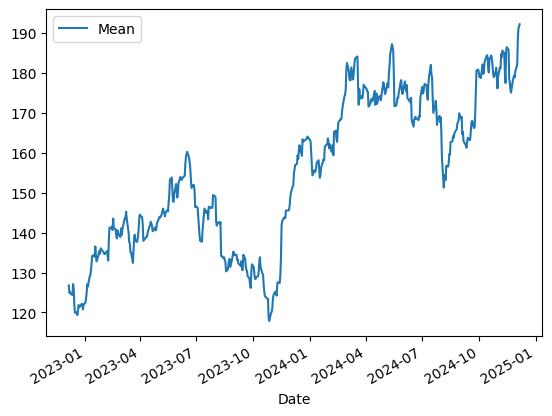

In [21]:
import matplotlib.pyplot as plt
df.info()
df.plot()

<Axes: xlabel='Date'>

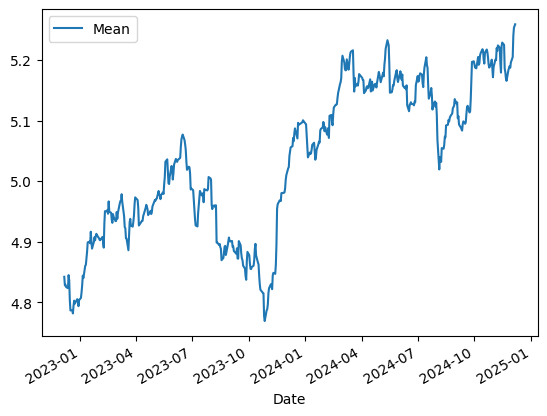

In [22]:
import numpy as np 
df = np.log(df) # don't forget to transform the data back when making real prediction

df.plot()

## Split the data into train and test

In [27]:
# from sklearn.model_selection import train_test_split
# X = df.index
# Y = df['Mean']
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# x_test

print(len(df))
print(int(len(df)*0.8))

df_train = df[:411].copy()
df_test = df[411:].copy()


514
411


## Step 1: Check for stationary time series

### Method #1: time series plot
from the previous plot we can see the time series has an up trend 

### Method #2: ACF plot and PACF plot

__ACF__: autocorrelation function.  
is the correlation of the time series with its lags, e.g., yt and yt-k for k 1,2,3...  
Time stamp a is correlated with time stamp b and b is correlated with c. So you have two correlations between data points:  
a -> c  
a -> b -> c

__PACF__: partial autocorrelation function.  
is the partial correlation of the time series with its lags, after removing the effects of the lower-order-lags between them.  
If b is compared pretty low we need just the **direct correlation**:  
a -> c

Video: https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf